# Analysis of intervention measures

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from os.path import join, isdir
from os import listdir
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl

import matplotlib
matplotlib.rc_file_defaults()

import warnings

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [81]:
src = "../../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"

results = pd.DataFrame()
files = [f for f in listdir(src) if not isdir(join(src, f)) and not "transmission" in f]
for f in files:
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])

results = results.reset_index(drop=True)
# subtract the index case
results["infected_agents"] = results["infected_agents"] - 1

# rename "overbooked" to 100% presence fraction, since a float is more handy
results["presence_fraction"] = results["presence_fraction"].replace({"overbooked": 1.0})

results["occupancy"] = results["presence_fraction"].apply(
    lambda x: "{}%".format(int(x * 100)) if x != "overbooked" else "overbooked"
)


In [82]:
results["scenario"] = np.nan
results = results.set_index(["unistudent_mask", "lecturer_mask", "presence_fraction"])
results.loc[(0, 0, 0.25), "scenario"] = "25% occupancy, no masks"
results.loc[(1, 1, 0.25), "scenario"] = "25% occupancy, masks"


results.loc[(0, 0, 0.5), "scenario"] = "50% occupancy, no masks"
results.loc[(1, 1, 0.5), "scenario"] = "50% occupancy, masks"

results.loc[(0, 0, 1), "scenario"] = "100% occupancy, no masks"
results.loc[(1, 1, 1), "scenario"] = "100% occupancy, masks"
results = results.reset_index()

results["transmission_risk_vaccination_modifier"] = results[
    "transmission_risk_vaccination_modifier"
].apply(eval)
results["transmission_risk_vaccination_modfier_reception"] = [
    i["reception"] for i in results["transmission_risk_vaccination_modifier"]
]

In [83]:
transmission_risk_vaccination_modfier_reception = 0.5
scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
    "25% occupancy, no masks",
    "25% occupancy, masks",
]

for scenario in scenarios:
    subset = results[
        (results["scenario"] == scenario)
        & (
    results["transmission_risk_vaccination_modfier_reception"]
    == transmission_risk_vaccination_modfier_reception
)
    ]
    print(
        "{}: {:1.1f}% of index cases do not lead to an outbreak".format(
            scenario,
            len(subset[subset["infected_agents"] == 0]) / len(subset) * 100,
        )
    )


100% occupancy, no masks: 26.1% of index cases do not lead to an outbreak
100% occupancy, masks: 43.0% of index cases do not lead to an outbreak
50% occupancy, no masks: 30.3% of index cases do not lead to an outbreak
50% occupancy, masks: 52.0% of index cases do not lead to an outbreak
25% occupancy, no masks: 42.1% of index cases do not lead to an outbreak
25% occupancy, masks: 62.0% of index cases do not lead to an outbreak


In [84]:
scenario = "25% occupancy, masks"
for transmission_risk_vaccination_modfier_reception in [0, 0.3, 0.5, 0.7]:
    subset = results[
        (results["scenario"] == scenario)
        & (
    results["transmission_risk_vaccination_modfier_reception"]
    == transmission_risk_vaccination_modfier_reception
    )
    ]
    print(
        "vaccination effectiveness {}: {:1.1f}% of index cases do not lead to an outbreak".format(
            transmission_risk_vaccination_modfier_reception,
            len(subset[subset["infected_agents"] == 0]) / len(subset) * 100,
        )
    )


vaccination effectiveness 0: 51.8% of index cases do not lead to an outbreak
vaccination effectiveness 0.3: 57.8% of index cases do not lead to an outbreak
vaccination effectiveness 0.5: 62.0% of index cases do not lead to an outbreak
vaccination effectiveness 0.7: 68.7% of index cases do not lead to an outbreak


In [85]:
outbreaks = results[results["infected_agents"] > 0].copy()

## Plots

### Kernel density plot measures

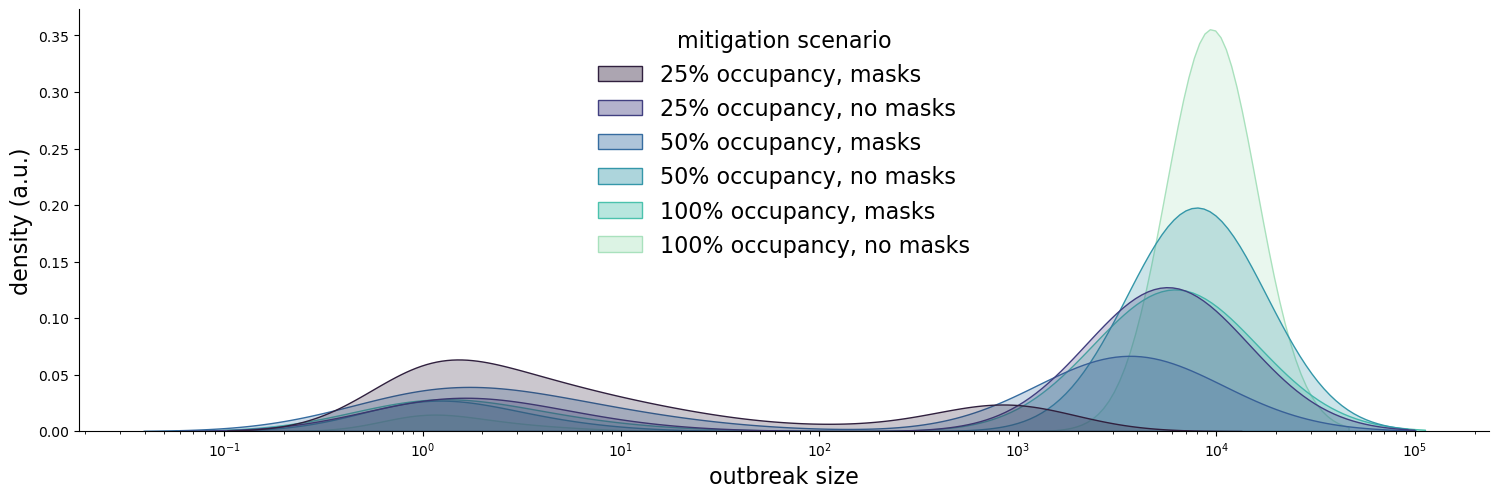

In [86]:
# select vaccination ratio and transmission risk modification by vaccination
# for the plot
transmission_risk_vaccination_modfier_reception = 0.5

cmap = sns.color_palette("mako", as_cmap=True)

scenarios.reverse()
colors = [cmap(0.9), cmap(0.75), cmap(0.6), cmap(0.45), cmap(0.3), cmap(0.15)]
colors.reverse()

subset = outbreaks[
    (outbreaks["scenario"].isin(scenarios))
    & (
        outbreaks["transmission_risk_vaccination_modfier_reception"]
        == transmission_risk_vaccination_modfier_reception
    )
]

g = sns.displot(
    subset,
    x="infected_agents",
    hue="scenario",
    kind="kde",
    fill=True,
    log_scale=True,
    height=5,
    aspect=3,
    hue_order=scenarios,
    palette=colors,
    legend=False
)

#g.axes[0][0].set_xlim(0, 1e5)
g.set_axis_labels("outbreak size", "density (a.u.)", fontsize=16)

facecolors = [(c[0], c[1], c[2], 0.4) for c in colors]
legend_elements = [Patch(label=l, fc=fc, ec=c) for c, fc, l in\
    zip(colors, facecolors, scenarios)]
legend = g.axes[0][0].legend(handles=legend_elements, loc=9, fontsize=16, 
    frameon=False, title="mitigation scenario")
plt.setp(legend.get_texts(), color='k')
plt.setp(legend.get_title(), color='k', fontsize=16)

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
          "axes.facecolor": "w",
          "savefig.facecolor": "w"}
plt.rcParams.update(params)
plt.savefig("../plots/outbreak_sizes.svg", facecolor="w")


### Kernel density plot vaccination effectiveness

<ipython-input-87-6bb5a298c0da>:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[0][0].set_xlim(0, 1e5)


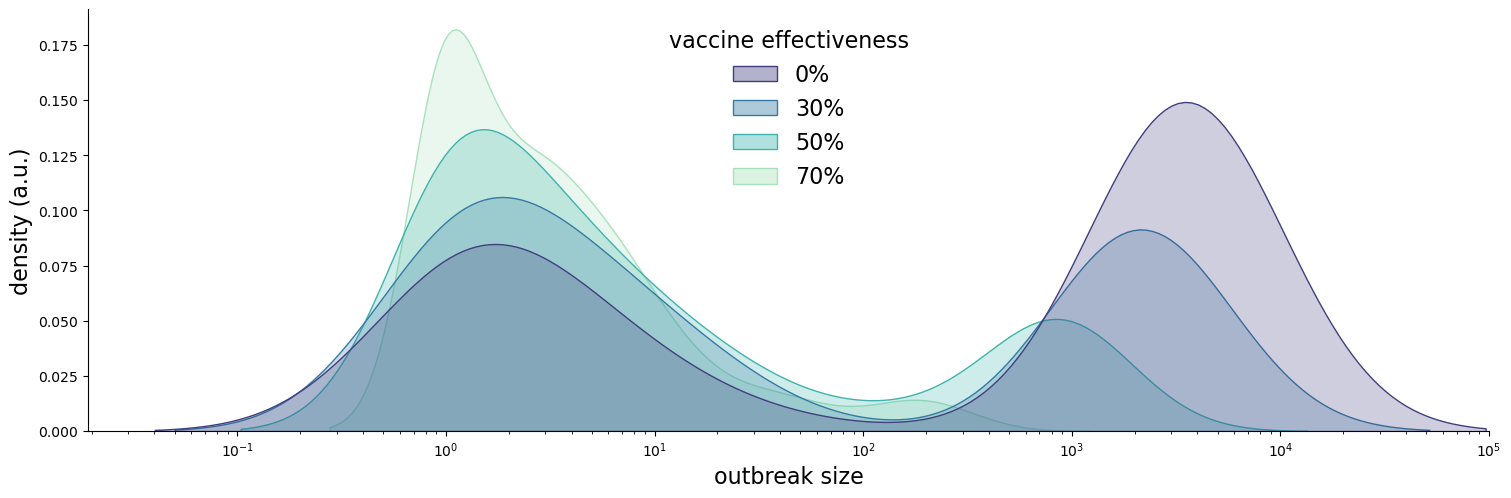

In [87]:
# select vaccination ratio and transmission risk modification by vaccination
# for the plot
transmission_risk_vaccination_modfier_reception = 0.4
scenario = "25% occupancy, masks"

cmap = sns.color_palette("mako", as_cmap=True)
vaccination_modfier_reception = [0.0, 0.3, 0.5, 0.7]
scenarios.reverse()
colors = [cmap(0.9), cmap(0.7), cmap(0.5), cmap(0.3)]
colors.reverse()

subset = outbreaks[
    (outbreaks["scenario"] == scenario)
    & (
        outbreaks["transmission_risk_vaccination_modfier_reception"].isin(
            vaccination_modfier_reception
        )
    )
]

g = sns.displot(
    subset,
    x="infected_agents",
    hue="transmission_risk_vaccination_modfier_reception",
    kind="kde",
    fill=True,
    log_scale=True,
    height=5,
    aspect=3,
    hue_order=vaccination_modfier_reception,
    palette=colors,
    legend=False
)

g.axes[0][0].set_xlim(0, 1e5)
g.set_axis_labels("outbreak size", "density (a.u.)", fontsize=16)

facecolors = [(c[0], c[1], c[2], 0.4) for c in colors]
legend_elements = [Patch(fc=fc, ec=c, label=f"{int(m*100)}%") for c, fc, m in\
    zip(colors, facecolors, vaccination_modfier_reception)]
legend = g.axes[0][0].legend(handles=legend_elements, loc=9, fontsize=16, 
    title="vaccine effectiveness", frameon=False)
plt.setp(legend.get_texts(), color='k')
plt.setp(legend.get_title(), color='k', fontsize=16)

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
          "axes.facecolor": "w",
          "savefig.facecolor": "w"}
plt.rcParams.update(params)
plt.savefig("../../plots/vaccine_effectiveness.svg", facecolor="w")


### Scatterplot outbreak probability

In [88]:
subset = results[results["infected_agents"] > 0]
subset[["scenario", "transmission_risk_vaccination_modfier_reception", "R0"]].groupby(
    ["scenario", "transmission_risk_vaccination_modfier_reception"]
).count()


R0
scenario                transmission_risk_vaccination_modfier_reception     
100% occupancy, masks   0.0                                              677
                        0.1                                              657
                        0.2                                              647
                        0.3                                              613
                        0.4                                              599
...                                                                      ...
50% occupancy, no masks 0.6                                              672
                        0.7                                              641
                        0.8                                              593
                        0.9                                              554
                        1.0                                              472

[66 rows x 1 columns]

In [89]:
N = 1000
subset = results[results["infected_agents"] > 0]
counts = (
    subset[["scenario", "transmission_risk_vaccination_modfier_reception", "R0"]]
    .groupby(["scenario", "transmission_risk_vaccination_modfier_reception"])
    .count()
    / N
)
counts = counts.reset_index().rename(columns={"R0": "outbreak_probability"})
counts.head(2)


,scenario,transmission_risk_vaccination_modfier_reception,outbreak_probability
0,"100% occupancy, masks",0.0,0.677
1,"100% occupancy, masks",0.1,0.657


Text(0.5, 0, 'vaccination effectiveness')

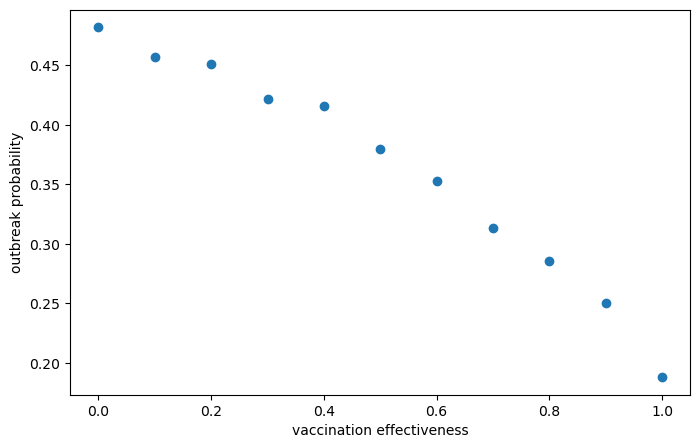

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))
col = "transmission_risk_vaccination_modfier_reception"
subset = counts[counts["scenario"] == "25% occupancy, masks"]
ax.scatter(subset[col], subset["outbreak_probability"])
ax.set_ylabel("outbreak probability")
ax.set_xlabel("vaccination effectiveness")


### Kernel density $R_\mathrm{eff}$ individual scenarios

In [91]:
src = "../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"
fnames = [
    "university_lmask-T_umask-T_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    ]
masks = [1, 0, 1, 0, 1, 0]
occupations = [1.0, 1.0, 0.5, 0.5, 0.25, 0.25]

scenarios = [
    "100% occupancy, masks",
    "100% occupancy, no masks",
    "50% occupancy, masks",
    "50% occupancy, no masks",
    "25% occupancy, masks",
    "25% occupancy, no masks",
]
R_values = pd.DataFrame()
for fname, scenario, mask, occupation in zip(fnames, scenarios, masks, occupations):
    tmp = pd.read_csv(join(src, fname), usecols=["R_100_avg", "R_100_std"])
    tmp["scenario"] = scenario
    tmp["unistudent_mask"] = mask
    tmp["lecturer_mask"] = mask
    tmp["presence_fraction"] = occupation
    tmp["transmission_risk_vaccination_modfier_reception"] = 0.5
    R_values = pd.concat([R_values, tmp])

R_values = R_values.set_index(["unistudent_mask", "lecturer_mask",
                               "presence_fraction", "transmission_risk_vaccination_modfier_reception"])
R_values = R_values.fillna(0)

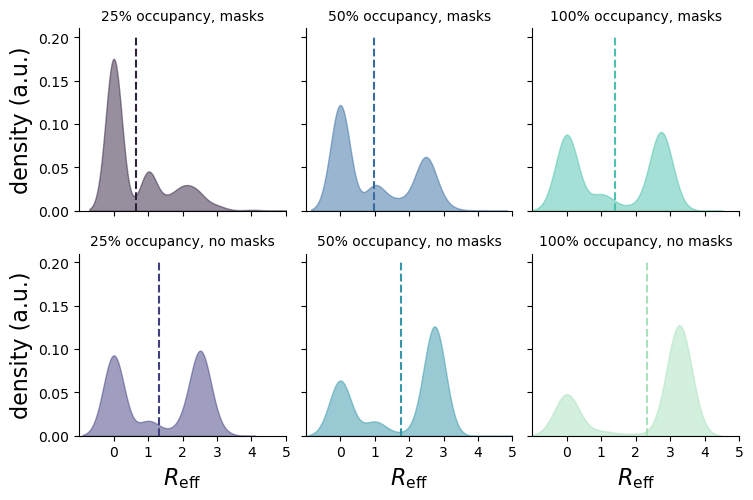

In [92]:
# select vaccination ratio and transmission risk modification by vaccination
# for the plot
vacc_ratio = 0.8
transmission_risk_vaccination_modfier_reception = 0.5

cmap = sns.color_palette("mako", as_cmap=True)

colmap = {
    "100% occupancy, no masks":3,
    "100% occupancy, masks":3,
    "50% occupancy, no masks":2,
    "50% occupancy, masks":2,
    "25% occupancy, no masks":1,
    "25% occupancy, masks":1,
}

rowmap = {
    "100% occupancy, no masks":2,
    "100% occupancy, masks":1,
    "50% occupancy, no masks":2,
    "50% occupancy, masks":1,
    "25% occupancy, no masks":2,
    "25% occupancy, masks":1,
}


colors = [cmap(0.9), cmap(0.75), cmap(0.6), cmap(0.45), cmap(0.3), cmap(0.15)]
colors.reverse()

R_values["col"] = R_values["scenario"].replace(colmap)
R_values["row"] = R_values["scenario"].replace(rowmap)

g = sns.displot(
    R_values,
    x="R_100_avg",
    col="col",
    kind="kde",
    fill=True,
    height=15 / 6,
    aspect=1,
    col_order=[1, 2, 3],
    row_order =[1, 2],
    row="row"
)

scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
    "25% occupancy, no masks",
    "25% occupancy, masks",
]
scenarios.reverse()
for i in range(3):
    for j in range(2):
        g.axes[j][i].set_xlim(-1, 5)
        g.axes[j][i].set_xticks(range(0, 6))
        g.axes[j][i].properties()["children"][0].set_color(colors[i*2 + j])
        g.axes[j][i].properties()["children"][0].set_alpha(0.5)
        g.axes[j][i].set_title(scenarios[i*2 + j], fontsize=10, color='k')
        mean_R = R_values[R_values["scenario"] == scenarios[i*2 + j]]["R_100_avg"].mean()
        g.axes[j][i].plot([mean_R, mean_R], [0, 0.2], '--', 
            color=colors[i*2 + j])
g.set_axis_labels("$R_\\mathrm{eff}$", "density (a.u.)", fontsize=16)
plt.savefig("../plots/R100.svg")


### Scatterplot vaccination effectiveness over $R$

In [93]:
def plot_mean_outcomes(ax, color, scenario, outcome, df, se=False):
    col = "transmission_risk_vaccination_modfier_reception"
    subset = df[df["scenario"] == scenario]

    mean_outcomes = (
        subset[[col, "infected_agents", "R0"]]
        .groupby(col)
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    ax.plot(
        mean_outcomes[col],
        mean_outcomes[outcome]["mean"],
        "o-",
        color=color,
        label=scenario,
    )
    if se:
        ax.fill_between(
            mean_outcomes[col],
            mean_outcomes[outcome]["mean"],
            mean_outcomes[outcome]["mean"]
            + mean_outcomes[outcome]["std"] / np.sqrt(mean_outcomes[outcome]["count"]),
            alpha=0.2,
            color=color,
        )
        ax.fill_between(
            mean_outcomes[col],
            mean_outcomes[outcome]["mean"],
            mean_outcomes[outcome]["mean"]
            - mean_outcomes[outcome]["std"] / np.sqrt(mean_outcomes[outcome]["count"]),
            alpha=0.2,
            color=color,
        )


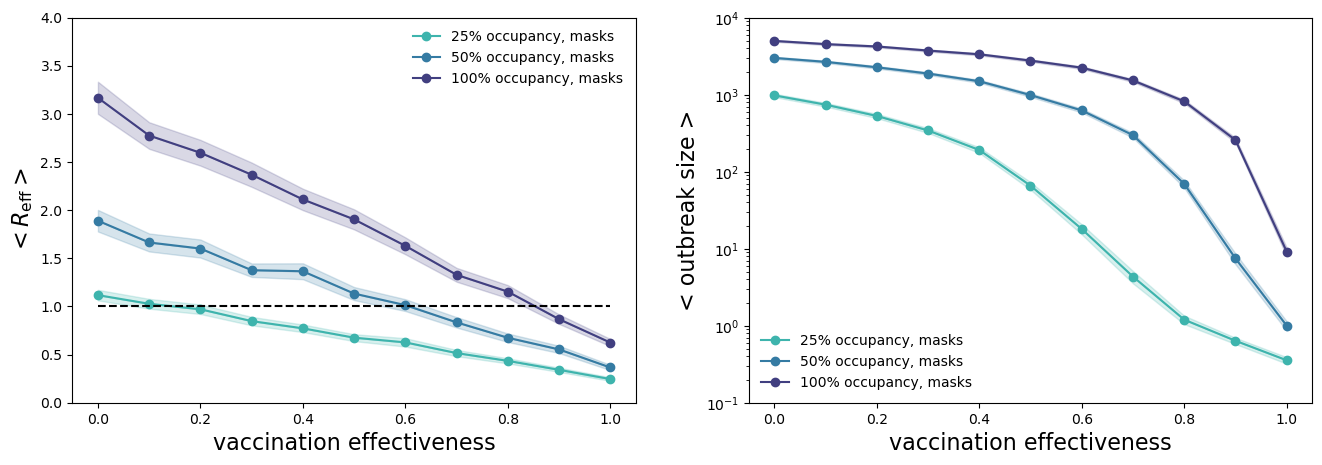

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_mean_outcomes(axes[0], cmap(0.7), "25% occupancy, masks", "R0", results, se=True)
plot_mean_outcomes(axes[0], cmap(0.5), "50% occupancy, masks", "R0", results, se=True)
plot_mean_outcomes(
    axes[0], cmap(0.3), "100% occupancy, masks", "R0", results, se=True
)
axes[0].set_ylabel("$< R_\mathrm{eff} >$", fontsize=16)
axes[0].set_xlabel("vaccination effectiveness", fontsize=16)
axes[0].set_ylim(0, 4.0)
axes[0].plot([0, 1.0], [1, 1], "--", color="k")
legend1 = axes[0].legend(frameon=False)

plot_mean_outcomes(
    axes[1], cmap(0.7), "25% occupancy, masks", "infected_agents", results, se=True
)
plot_mean_outcomes(
    axes[1], cmap(0.5), "50% occupancy, masks", "infected_agents", results, se=True
)
plot_mean_outcomes(
    axes[1], cmap(0.3), "100% occupancy, masks", "infected_agents", results, se=True
)
axes[1].set_ylabel("< outbreak size >", fontsize=16)
axes[1].set_xlabel("vaccination effectiveness", fontsize=16)
axes[1].set_ylim(1e-1, 1e4)
axes[1].set_yscale("log")
legend2 = axes[1].legend(frameon=False)

printcolors = {
    True:{"facecolor":"w",
           "textcolor":"k"},
    False:{"facecolor":"k",
           "textcolor":"w"}
}

doprint = True
facecolor = printcolors[doprint]["facecolor"]
textcolor = printcolors[doprint]["textcolor"]

params = {"ytick.color" : textcolor,
          "xtick.color" : textcolor,
          "axes.labelcolor" : textcolor,
          "axes.edgecolor" : textcolor,
          "axes.facecolor": facecolor,
          "savefig.facecolor": facecolor}

fig.patch.set_facecolor(facecolor)
plt.setp(legend1.get_texts(), color=textcolor)
plt.setp(legend2.get_texts(), color=textcolor)
plt.rcParams.update(params)
plt.savefig("../plots/mean_outcomes.svg", facecolor="w")


### Lineplot R time series

In [95]:
src = "../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"
fnames = [
    "university_lmask-F_umask-F_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-{}_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-{}_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-{}_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-{}_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-{}_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-{}_transmissions.csv",
    ]
labels = [
    "100% occupancy, masks",
    "100% occupancy, no masks",
    "50% occupancy, masks",
    "50% occupancy, no masks",
    "25% occupancy, masks",
    "25% occupancy, no masks",
]

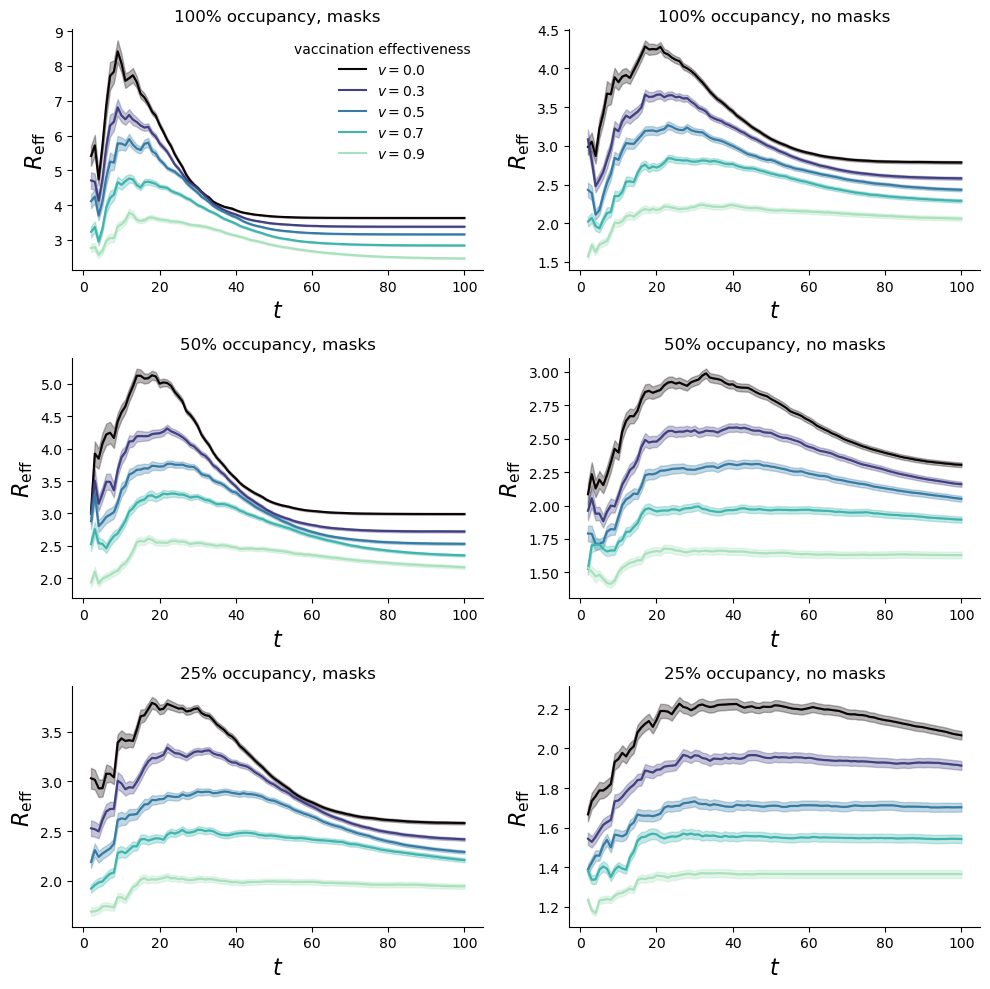

In [96]:
def plot_R_values(ax, df, vaccmod, label, legend):
    cmap = sns.color_palette("mako", as_cmap=True)
    err = df[[f"R_{i}_avg" for i in cutoffs]].std() / np.sqrt(len(R_values))
    ax.plot(cutoffs, df[[f"R_{i}_avg" for i in cutoffs]].mean(), 
        color=cmap(vaccmod), label=f"$v = {vaccmod}$")
    ax.fill_between(cutoffs, 
                    df[[f"R_{i}_avg" for i in cutoffs]].mean(), 
                    df[[f"R_{i}_avg" for i in cutoffs]].mean() + err,
                    alpha=0.3, color=cmap(vaccmod))
    ax.fill_between(cutoffs, 
                    df[[f"R_{i}_avg" for i in cutoffs]].mean(), 
                    df[[f"R_{i}_avg" for i in cutoffs]].mean() - err,
                    alpha=0.3, color=cmap(vaccmod))
    ax.set_title(label)
    ax.set_ylabel("$R_\\mathrm{eff}$", fontsize=16)
    ax.set_xlabel("$t$", fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if legend:
        ax.legend(title="vaccination effectiveness", frameon=False)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
cutoffs = range(1, 101)
vaccmods = [0.0, 0.3, 0.5, 0.7, 0.9]

for fname, label, ax in zip(fnames, labels, axes.flatten()):
    files = [fname.format(i) for i in vaccmods]
    for f, vaccmod in zip(files, vaccmods):
        R_values = pd.read_csv(join(src, f))
        if label == "100% occupancy, masks":
            legend = True
        else:
            legend = False
        plot_R_values(ax, R_values, vaccmod, label, legend)

#ax_divider = make_axes_locatable(axes[0, 1])
#cax = ax_divider.append_axes("right", size="5%", pad="2%")
#cmap = sns.color_palette("mako", as_cmap=True)
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
#fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#             cax=cax, orientation='vertical', label='vaccination effectiveness')
fig.tight_layout()
plt.savefig("../plots/R_values.svg", facecolor="w")

## Stats

In [97]:
def print_stats(df, sm, lm, pf, ve, stat):
    """
    Parameters:
    -----------
    df: pandas DataFrame
        Simulation data of outbreaks
    sm: integer (0, 1)
        Student masks
    lm: integer (0, 1)
        Lecturer masks
    pf: float (0.25, 0.5, 1.0)
        Fraction of students present in lecture halls
    ve: float
        Effectiveness of vaccination against infection
    stat: string ('infected_agents' or 'RO')
        Observable for which statistics should be calculated
    """
    print("************* {} *************".format(stat))
    print(
        "student masks: {}, lecturer masks: {}, presence fraction: {}, vaccination effectiveness: {}".format(
            sm, lm, pf, ve
        )
    )
    print("mean {}: ".format(df.loc[sm, lm, pf, ve][stat].mean()))
    print(
        "95% credible interval: [{}; {}] ".format(
            df.loc[sm, lm, pf, ve][stat].quantile(0.025),
            df.loc[sm, lm, pf, ve][stat].quantile(0.975),
        )
    )
    print("maximum {}: ".format(df.loc[sm, lm, pf, ve][stat].max()))
    print("**************************")
    print()


### 50% vaccine effectiveness

In [98]:
src = "../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"
fnames = [
    "university_lmask-T_umask-T_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    ]
masks = [1, 0, 1, 0, 1, 0]
occupations = [1.0, 1.0, 0.5, 0.5, 0.25, 0.25]

scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
    "25% occupancy, no masks",
    "25% occupancy, masks",
]
R_values = pd.DataFrame()
for fname, scenario, mask, occupation in zip(fnames, scenarios, masks, occupations):
    tmp = pd.read_csv(join(src, fname), usecols=["R_100_avg", "R_100_std"])
    tmp["scenario"] = scenario
    tmp["unistudent_mask"] = mask
    tmp["lecturer_mask"] = mask
    tmp["presence_fraction"] = occupation
    tmp["transmission_risk_vaccination_modfier_reception"] = 0.5
    R_values = pd.concat([R_values, tmp])

R_values = R_values.set_index(["unistudent_mask", "lecturer_mask",
                               "presence_fraction", "transmission_risk_vaccination_modfier_reception"])
R_values = R_values.fillna(0)

In [99]:
transmission_risk_vaccination_modfier_reception = 0.5

subset = results[
    results["transmission_risk_vaccination_modfier_reception"]
    == transmission_risk_vaccination_modfier_reception
].copy()

subset = subset.set_index(
    [
        "unistudent_mask",
        "lecturer_mask",
        "presence_fraction",
        "transmission_risk_vaccination_modfier_reception",
    ]
)


In [100]:
src = "../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"
fnames = [
    "university_lmask-T_umask-T_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.5_transmissions.csv",
    ]
masks = [1, 0, 1, 0, 1, 0]
occupations = [1.0, 1.0, 0.5, 0.5, 0.25, 0.25]

scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
    "25% occupancy, no masks",
    "25% occupancy, masks",
]
R_values = pd.DataFrame()
for fname, scenario, mask, occupation in zip(fnames, scenarios, masks, occupations):
    tmp = pd.read_csv(join(src, fname), usecols=["R_100_avg", "R_100_std"])
    tmp["scenario"] = scenario
    tmp["unistudent_mask"] = mask
    tmp["lecturer_mask"] = mask
    tmp["presence_fraction"] = occupation
    tmp["transmission_risk_vaccination_modfier_reception"] = 0.5
    R_values = pd.concat([R_values, tmp])

R_values = R_values.set_index(["unistudent_mask", "lecturer_mask",
                               "presence_fraction", "transmission_risk_vaccination_modfier_reception"])
R_values = R_values.fillna(0)

In [101]:
# 100 % occupancy
print("*************************")
print("***** 100% occupancy ****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 1, 0.5, "infected_agents")
print_stats(R_values, 0, 0, 1, 0.5, "R_100_avg")

# 100 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 1, 0.5, "infected_agents")
print_stats(R_values, 1, 1, 1, 0.5, "R_100_avg")

# 50 % occupancy
print("*************************")
print("***** 50% occupancy *****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 0.5, 0.5, "infected_agents")
print_stats(R_values, 0, 0, 0.5, 0.5, "R_100_avg")

# 50 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 0.5, 0.5, "infected_agents")
print_stats(R_values, 1, 1, 0.5, 0.5, "R_100_avg")

# 25 % occupancy
print("*************************")
print("***** 25% occupancy *****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 0.25, 0.5, "infected_agents")
print_stats(R_values, 0, 0, 0.25, 0.5, "R_100_avg")

# 25 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 0.25, 0.5, "infected_agents")
print_stats(R_values, 1, 1, 0.25, 0.5, "R_100_avg")


*************************
***** 100% occupancy ****
*************************

>>> no maks <<<
************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination effectiveness: 0.5
mean 6598.96: 
95% credible interval: [0.0; 9517.050000000001] 
maximum 9598.0: 
**************************

************* R_100_avg *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination effectiveness: 0.5
mean 2.3372442575963803: 
95% credible interval: [0.0; 3.3392798644429442] 
maximum 3.385642135642136: 
**************************

>>> masks <<<
************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination effectiveness: 0.5
mean 2777.314: 
95% credible interval: [0.0; 6323.025] 
maximum 6406.0: 
**************************

************* R_100_avg *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination effectiveness: 0.5
mean 1.3865473020690227: 

### 70% vaccine effectiveness

In [102]:
src = "../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"
fnames = [
    "university_lmask-T_umask-T_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.7_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.7_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.7_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.7_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.7_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.7_transmissions.csv",
    ]
masks = [1, 0, 1, 0, 1, 0]
occupations = [1.0, 1.0, 0.5, 0.5, 0.25, 0.25]

scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
    "25% occupancy, no masks",
    "25% occupancy, masks",
]
R_values = pd.DataFrame()
for fname, scenario, mask, occupation in zip(fnames, scenarios, masks, occupations):
    tmp = pd.read_csv(join(src, fname), usecols=["R_100_avg", "R_100_std"])
    tmp["scenario"] = scenario
    tmp["unistudent_mask"] = mask
    tmp["lecturer_mask"] = mask
    tmp["presence_fraction"] = occupation
    tmp["transmission_risk_vaccination_modfier_reception"] = 0.7
    R_values = pd.concat([R_values, tmp])

R_values = R_values.set_index(["unistudent_mask", "lecturer_mask",
                               "presence_fraction", "transmission_risk_vaccination_modfier_reception"])
R_values = R_values.fillna(0)

In [103]:
transmission_risk_vaccination_modfier_reception = 0.7

subset = results[
    results["transmission_risk_vaccination_modfier_reception"]
    == transmission_risk_vaccination_modfier_reception
].copy()

subset = subset.set_index(
    [
        "unistudent_mask",
        "lecturer_mask",
        "presence_fraction",
        "transmission_risk_vaccination_modfier_reception",
    ]
)


In [104]:
# 100 % occupancy
print("*************************")
print("***** 100% occupancy ****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 1, 0.7, "infected_agents")
print_stats(R_values, 0, 0, 1, 0.7, "R_100_avg")

# 100 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 1, 0.7, "infected_agents")
print_stats(R_values, 1, 1, 1, 0.7, "R_100_avg")

# 50 % occupancy
print("*************************")
print("***** 50% occupancy *****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 0.5, 0.7, "infected_agents")
print_stats(R_values, 0, 0, 0.5, 0.7, "R_100_avg")

# 50 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 0.5, 0.7, "infected_agents")
print_stats(R_values, 1, 1, 0.5, 0.7, "R_100_avg")

# 25 % occupancy
print("*************************")
print("***** 25% occupancy *****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 0.25, 0.7, "infected_agents")
print_stats(R_values, 0, 0, 0.25, 0.7, "R_100_avg")

# 25 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 0.25, 0.7, "infected_agents")
print_stats(R_values, 1, 1, 0.25, 0.7, "R_100_avg")


*************************
***** 100% occupancy ****
*************************

>>> no maks <<<
************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination effectiveness: 0.7
mean 5113.779: 
95% credible interval: [0.0; 8374.0] 
maximum 8466.0: 
**************************

************* R_100_avg *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination effectiveness: 0.7
mean 1.9709229628660905: 
95% credible interval: [0.0; 3.0948448721306465] 
maximum 4.0: 
**************************

>>> masks <<<
************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination effectiveness: 0.7
mean 1533.076: 
95% credible interval: [0.0; 4633.025000000001] 
maximum 4844.0: 
**************************

************* R_100_avg *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination effectiveness: 0.7
mean 1.1308423094889442: 
95% credible i

### 90% vaccine effectiveness

In [105]:
src = "../data/simulation_results/omicron/ensembles_intervention_screening_omicron_all"
fnames = [
    "university_lmask-T_umask-T_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.9_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-overbooked_uvacc-0.8_lvacc-0.8_vaccmod-0.9_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.9_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.5_uvacc-0.8_lvacc-0.8_vaccmod-0.9_transmissions.csv",
    "university_lmask-T_umask-T_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.9_transmissions.csv",
    "university_lmask-F_umask-F_pfrac-0.25_uvacc-0.8_lvacc-0.8_vaccmod-0.9_transmissions.csv",
    ]
masks = [1, 0, 1, 0, 1, 0]
occupations = [1.0, 1.0, 0.5, 0.5, 0.25, 0.25]

scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
    "25% occupancy, no masks",
    "25% occupancy, masks",
]
R_values = pd.DataFrame()
for fname, scenario, mask, occupation in zip(fnames, scenarios, masks, occupations):
    tmp = pd.read_csv(join(src, fname), usecols=["R_100_avg", "R_100_std"])
    tmp["scenario"] = scenario
    tmp["unistudent_mask"] = mask
    tmp["lecturer_mask"] = mask
    tmp["presence_fraction"] = occupation
    tmp["transmission_risk_vaccination_modfier_reception"] = 0.9
    R_values = pd.concat([R_values, tmp])

R_values = R_values.set_index(["unistudent_mask", "lecturer_mask",
                               "presence_fraction", "transmission_risk_vaccination_modfier_reception"])
R_values = R_values.fillna(0)

In [106]:
transmission_risk_vaccination_modfier_reception = 0.9

subset = results[
    results["transmission_risk_vaccination_modfier_reception"]
    == transmission_risk_vaccination_modfier_reception
].copy()

subset = subset.set_index(
    [
        "unistudent_mask",
        "lecturer_mask",
        "presence_fraction",
        "transmission_risk_vaccination_modfier_reception",
    ]
)


In [107]:
# 100 % occupancy
print("*************************")
print("***** 100% occupancy ****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 1, 0.9, "infected_agents")
print_stats(R_values, 0, 0, 1, 0.9, "R_100_avg")

# 100 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 1, 0.9, "infected_agents")
print_stats(R_values, 1, 1, 1, 0.9, "R_100_avg")

# 50 % occupancy
print("*************************")
print("***** 50% occupancy *****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 0.5, 0.9, "infected_agents")
print_stats(R_values, 0, 0, 0.5, 0.9, "R_100_avg")

# 50 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 0.5, 0.9, "infected_agents")
print_stats(R_values, 1, 1, 0.5, 0.9, "R_100_avg")

# 25 % occupancy
print("*************************")
print("***** 25% occupancy *****")
print("*************************")
print()
print(">>> no maks <<<")
print_stats(subset, 0, 0, 0.25, 0.9, "infected_agents")
print_stats(R_values, 0, 0, 0.25, 0.9, "R_100_avg")

# 25 % occupancy & masks
print(">>> masks <<<")
print_stats(subset, 1, 1, 0.25, 0.9, "infected_agents")
print_stats(R_values, 1, 1, 0.25, 0.9, "R_100_avg")


*************************
***** 100% occupancy ****
*************************

>>> no maks <<<
************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination effectiveness: 0.9
mean 2392.68: 
95% credible interval: [0.0; 5085.025] 
maximum 5289.0: 
**************************

************* R_100_avg *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination effectiveness: 0.9
mean 1.5422163037807326: 
95% credible interval: [0.0; 2.8737115006139713] 
maximum 4.0: 
**************************

>>> masks <<<
************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination effectiveness: 0.9
mean 257.858: 
95% credible interval: [0.0; 1616.1499999999999] 
maximum 1778.0: 
**************************

************* R_100_avg *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination effectiveness: 0.9
mean 0.8417243467845533: 
95% credible 